# Tutorial 1: Classifying Iris flowers

In this tutorial, we'll use [pandas](https://pandas.pydata.org/), [TensorFlow](https://www.tensorflow.org/), and other Python libraries to classify Iris flowers by species. The data we will explore is from Fisher's famous [_Iris_ flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set), introduced in his 1936 paper on linear discriminant analysis. This data set has become one of the canonical introductions to machine learning classification problems.

By the end of the lesson, we will be able to:

* Build intuition for an ML model on a data set by drawing correlation plots between features.
* Preprocess data using TensorFlow and pandas tools, and generate training and testing data sets.
* Build a simple model using TensorFlow and evaluate it using model metrics like accuracy.
* Observe the effect of changing the set of features used as input to the network.

## The Iris classification problem

Imagine you are a botanist seeking an automated way to classify each Iris flower you find. Through extensive field work, you have collected a sample of Iris flowers, and want to use this sample to develop techniques for identifying which species it is. You could use sophisticated machine learning methods to, say, classify flowers based on photographs. Our ambitions are more modest--we're going to classify Iris flowers based solely on the length and width of their sepals and petals.

The Iris genus entails about 300 species, but we will classify only the following three:

* Iris setosa
* Iris virginica
* Iris versicolor

![Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor](images/iris_three_species.jpg)
**From left to right, _[Iris setosa](https://commons.wikimedia.org/w/index.php?curid=170298)_ (by [Radomil](https://commons.wikimedia.org/wiki/User:Radomil), CC BY-SA 3.0), _[Iris versicolor](https://commons.wikimedia.org/w/index.php?curid=248095)_ (by [Dlanglois](https://commons.wikimedia.org/wiki/User:Dlanglois), CC BY-SA 3.0), and _[Iris virginica](https://www.flickr.com/photos/33397993@N05/3352169862)_ (by [Frank Mayfield](https://www.flickr.com/photos/33397993@N05), CC BY-SA 2.0).**

## Getting the data

Because of its popularity as a simple data set, Iris data is available as part of many machine learning and data analysis libraries. For the purposes of this tutorial, we will download it in raw form from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/iris), and process it for use in this tutorial.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport tutorial.datasets
%aimport tutorial.tf_functions

In [2]:
data, species = tutorial.datasets.load_iris_dataset()
data.head(5) # Inspect first 5 rows of data set

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Each row in this data set corresponds to a particular _Iris_ flower. We will call a row an **example**.

There are four characteristics of the flowers: sepal length, sepal width, petal length, and petal width. These will be our **features**. The `species` column corresponds to the type of _Iris_ flower the row corresponds to, which we will convert to **labels** in the next section.

We can quickly print some summary statistics for the data set.

In [3]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


As we can see, the entire data set consists of exactly 150 examples, which is why this is considered a _toy_ data set.

### Visual inspection of the data

For really quick visual insight into the data and correlation between its features, we can draw a pairwise plot of relationships between features. This is the fastest way to build intuition for an ML model on these features.

/usr/local/miniconda3/envs/ml_tutorials/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


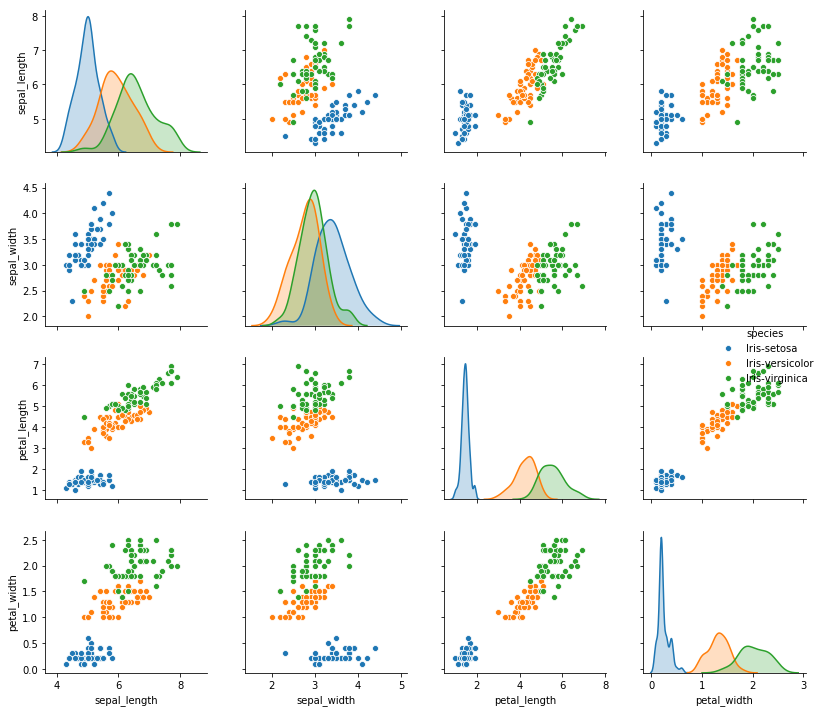

In [4]:
%matplotlib inline
import seaborn as sns

sns.pairplot(data, kind='scatter', hue='species')

**A pairwise plot of relationships between features of the Iris data set.**

Since there are 4 features, `pairplot` produces a 4 $\times$ 4 grid, one for each pair of features $x$ and $y$. On the diagonal (i.e. where both $x$ and $y$ are the same feature), we see a histogram of values for that feature. Everywhere else, we see a scatter plot between $x$ and $y$. Additionally, each data point on the plots is colored with the species corresponding to the data set.

Let's gather some insights from these plots. What do the clusters of different colored data points on the scatter plots tell us? (Hint: we're trying to build an ML model that learns to "separate" examples of different species using petal and sepal length features)

## Pre-processing the data

Before we build an ML model with the data set, let's do some additional pre-processing.

1. We'll first assign numerical _labels_ corresponding to the three species of _Iris_ flower. This is to make it easier to train models on this data set, as machine learning typically relies on numeric values.

2. We will then split the data set into _training_ and _test_ sets.

### Assigning numerical labels

We will assign values of 0, 1, 2 to a row depending on the species it represents. These will be our **labels**.

In [5]:
species_mapping = {species: i for i, species in enumerate(species)}
data_with_labels = data.assign(species=lambda x: [species_mapping[s] for s in x.species])
data_with_labels.sample(n=5) # Inspect 5 random examples from data set with numeric labels

,sepal_length,sepal_width,petal_length,petal_width,species
33,5.5,4.2,1.4,0.2,0
120,6.9,3.2,5.7,2.3,2
82,5.8,2.7,3.9,1.2,1
126,6.2,2.8,4.8,1.8,2
31,5.4,3.4,1.5,0.4,0


### Splitting into training and test data sets

The **training** set contains the examples that we'll use to train the model; the **test** set contains the examples that we'll use to evaluate the trained model's effectiveness.

Since we're starting with a single data set of 150 examples, we'll be splitting this into the two sets. The choice of split ratio is an important one. Adding examples to the training set usually builds a better model; however, adding more examples to the test set enables us to better gauge the model's effectiveness. In many ML applications, an 80% training and 20% testing split is fairly common, so we'll use that.

Note that we need to make sure the data is well-shuffled before we split out the two sets, otherwise there is a chance that the two data sets might suffer from [bias](https://en.wikipedia.org/wiki/Sampling_bias).

In [6]:
train_data = data_with_labels.sample(frac=0.8, random_state=200) # 80% of examples for the training set
test_data = data_with_labels.drop(train_data.index).sample(frac=1, random_state=200)

Note that we fixed the random state for the call to the sample method. This still guarantees that the data set will be shuffled, but also that it will be shuffled in a consistent way across executions of this method.

Finally, we need to separate the set of _features_ we will use in our model (we call this `x`), and the set of _labels_ (we call this `y`).

In [7]:
train_x, train_y = train_data.drop('species', axis=1), train_data['species']
test_x, test_y = test_data.drop('species', axis=1), test_data['species']
print(train_x.head(4))
print(train_y.head(4))
print(test_x.head(4))
print(test_y.head(4))

     sepal_length  sepal_width  petal_length  petal_width
84            5.4          3.0           4.5          1.5
122           7.7          2.8           6.7          2.0
28            5.2          3.4           1.4          0.2
24            4.8          3.4           1.9          0.2
84     1
122    2
28     0
24     0
Name: species, dtype: int64
     sepal_length  sepal_width  petal_length  petal_width
134           6.1          2.6           5.6          1.4
147           6.5          3.0           5.2          2.0
14            5.8          4.0           1.2          0.2
120           6.9          3.2           5.7          2.3
134    2
147    2
14     0
120    2
Name: species, dtype: int64


## Building a model

A **model** is the relationship between features and the label. For the Iris problem, the model defines the relationship between the sepal and petal measurements and the predicted Iris species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the four features and the Iris species _without_ using machine learning? That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model? Maybe. You could play with the data set long enough to determine the right relationships of petal and sepal measurements to particular species. However, a good machine learning approach determines the model for you. That is, if you feed enough representative examples into the right machine learning model type, the program will determine the relationship between sepals, petals, and species.

Training is the stage of machine learning in which the model is gradually optimized (learned). The Iris problem is an example of **supervised machine learning** in which a model is trained from examples that contain labels.

Let's begin by importing the TensorFlow library.

In [8]:
import tensorflow as tf

### Create feature columns

A **feature column** is a data structure that tells your model how to interpret the data in each feature. In the Iris problem, we want the model to interpret the data in each feature as its literal floating-point value; that is, we want the model to interpret an input value like 5.4 as, well, 5.4. However, in other machine learning problems, it is often desirable to interpret data less literally. Using feature columns to interpret data is such a rich topic that we devote an entire document to it.

From a code perspective, you build a list of feature_column objects by calling functions from the `tf.feature_column` module. Each object describes an input to the model. To tell the model to interpret data as a floating-point value, call `tf.feature_column.numeric_column`. For the Iris problem, all four features should be interpreted as literal floating-point values, so the code to create a feature column looks as follows:

In [9]:
my_feature_columns = [tf.feature_column.numeric_column(k) for k in train_x.keys()]

### Select the type of model

We need to select the kind of model that will be trained. Lots of model types exist; picking the ideal type takes experience. We've selected a neural network to solve the Iris problem. **Neural networks** can find complex relationships between features and the label. A neural network is a highly-structured graph, organized into one or more **hidden layers**. Each hidden layer consists of one or more neurons. There are several categories of neural networks. We'll be using a **fully connected neural network**, which means that the neurons in one layer take inputs from every neuron in the previous layer. For example, the following figure illustrates a fully connected neural network consisting of three hidden layers:

* The first hidden layer contains four neurons.
* The second hidden layer contains three neurons.
* The third hidden layer contains two neurons.

![A three layer fully connected neural network with 4, 3, and 2 neurons in the three hidden layers](images/simple_dnn.svg)
**A neural network with three hidden layers.**

We can build a fully connected neural network for the Iris problem by using a pre-made [Estimator](https://developers.google.com/machine-learning/glossary/#Estimators) named `tf.estimator.DNNClassifier`.

In [10]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[10, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmp0eozss0m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12419f4a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


The length of the list assigned to `hidden_units` identifies the number of hidden layers (2, in this case). Each value in the list represents the number of neurons in a particular hidden layer (10 in the first hidden layer and 10 in the second hidden layer).

The ideal number of hidden layers and neurons depends on the problem and the data set. Like many aspects of machine learning, picking the ideal shape of the neural network requires some mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons _typically_ creates a more powerful model, which requires more data to train effectively.

The `n_classes` parameter specifies the number of possible values that the neural network can predict. Since the Iris problem classifies 3 Iris species, we set n_classes to 3.

### Train the model

Instantiating a `tf.Estimator.DNNClassifier` creates a framework for learning the model. Basically, we've wired a network but haven't yet let data flow through it. To train the neural network, call the Estimator object's `train` method.

In [11]:
classifier.train(
    input_fn=lambda:tutorial.tf_functions.train_input_fn(train_x, train_y, batch_size=100),
    steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmp0eozss0m/model.ckpt.
INFO:tensorflow:loss = 175.13788, step = 1
INFO:tensorflow:global_step/sec: 537.638
INFO:tensorflow:loss = 22.702557, step = 101 (0.187 sec)
INFO:tensorflow:global_step/sec: 770.13
INFO:tensorflow:loss = 9.96587, step = 201 (0.130 sec)
INFO:tensorflow:global_step/sec: 744.747
INFO:tensorflow:loss = 8.973883, step = 301 (0.135 sec)
INFO:tensorflow:global_step/sec: 707.508
INFO:tensorflow:loss = 5.4080987, step = 401 (0.141 sec)
INFO:tensorflow:global_step/sec: 696.204
INFO:tensorflow:loss = 5.199802, step = 501 (0.143 sec)
INFO:tensorflow:global_step/sec: 802.834
INFO:tensorflow:loss = 5.6669645, step = 601 (0.125 sec)
INFO:tensorflow:gl

### Evaluate the model

We can now evaluate the model to determine how effectively it makes predictions. We use examples from our test set to get predictions from our trained model, and compare them against the actual label.

We usually quantify the model effectiveness through a number of **model metrics**. In this case, we'll look at model **accuracy**, which is the fraction of examples that the model gets right. For example, a model that picked the correct species on half the input examples would have an accuracy of 0.5.

In [12]:
eval_result = classifier.evaluate(
    input_fn=lambda:tutorial.tf_functions.eval_input_fn(test_x, test_y, batch_size=1000))

print('\nTest set accuracy: {:0.3f}\n'.format(eval_result['accuracy']))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17-05:44:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmp0eozss0m/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-05:44:42
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.96666664, average_loss = 0.080710664, global_step = 1000, loss = 2.42132
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmp0eozss0m/model.ckpt-1000

Test set accuracy: 0.967



You'll see that the accuracy on this set is quite high. Our trained model should be able to correctly classify more than 27 of the 30 Iris species in the test set. This kind of accuracy is relatively to achieve on a toy data set like Iris.

### Predicting on new examples

We can now use the trained model to make some predictions on unlabeled examples; that is, on examples that contain features but not a label.

In [13]:
 predict_x = {
     'sepal_length': [5.1, 5.9, 6.9],
     'sepal_width': [3.3, 3.0, 3.1],
     'petal_length': [1.7, 4.2, 5.4],
     'petal_width': [0.5, 1.5, 2.1]
}
    
predictions = classifier.predict(
    input_fn=lambda:tutorial.tf_functions.eval_input_fn(predict_x,
                                                        labels=None,
                                                        batch_size=100))

for prediction in predictions:
    class_id = prediction['class_ids'][0]
    probabilities = prediction['probabilities']
    print("\nProbabilies: {}. Prediction is '{}' ({:.1f}%)\n"
          .format(probabilities,
                  species[class_id],
                  probabilities[class_id] * 100))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmp0eozss0m/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Probabilies: [9.9498725e-01 5.0128191e-03 8.6620098e-09]. Prediction is 'Iris-setosa' (99.5%)


Probabilies: [2.3399065e-04 9.9410856e-01 5.6575811e-03]. Prediction is 'Iris-versicolor' (99.4%)


Probabilies: [1.7535146e-07 2.8059838e-02 9.7193998e-01]. Prediction is 'Iris-virginica' (97.2%)



For each unlabelled example, the model produces a set of 3 probabilities for each example, where each probability is the likeilihood belongs to that class.

## Experimenting with number of input features

In the above section, we built a model using all 4 available features. We also picked two-layer neural network with 10 units in each layer. Usually, in real world problems where we try ML on a new data set, we already have access to a number of features that we can "throw" into the model to evaluate. This is not an infeasible idea, given the scope and scale of hardware, capacity, and processing power available to us!

However, in this section, we'll build some intuition of why feature selection for ML problems is relevant. We will study what happens to metrics like accuracy when we select only a limited subset of features for model training.

Since we'll be trying different subsets of features on the same neural network, let's define a method to combine the steps of (1) producing a `DNNClassifier` specification, (2) training, and (3) evaluating a model using a subset of features as input. we've written a method `iris_classifier_with_features` which produces the same `DNNClassifier` neural network we built above, but allows us to specify a subset of features as input.

In [14]:
def train_and_evaluate_on_subset(feature_names):
    subset_feature_columns = [tf.feature_column.numeric_column(k) for k in feature_names]
    subset_classifier = tf.estimator.DNNClassifier(
        feature_columns=subset_feature_columns,
        hidden_units=[10, 10],
        n_classes=3)
    subset_classifier.train(
        input_fn=lambda:tutorial.tf_functions.train_input_fn(train_x, train_y, batch_size=100),
        steps=1000)
    subset_eval_result = subset_classifier.evaluate(
        input_fn=lambda:tutorial.tf_functions.eval_input_fn(test_x, test_y, batch_size=1000))
    print('\nTest set accuracy with features {}: {:0.3f}\n'.format(feature_names, subset_eval_result['accuracy']))    

Let's try training and evaluating on a particular subset of features: `sepal_length` and `sepal_width`.

In [15]:
train_and_evaluate_on_subset(['sepal_length', 'sepal_width'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpcd_aepsz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x124a454a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 i

As you can see, the accuracy of the model when we train on just sepal and petal length is very low (< 75%). Why is that? Let's plot a correlation between these two features to find out.

/usr/local/miniconda3/envs/ml_tutorials/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


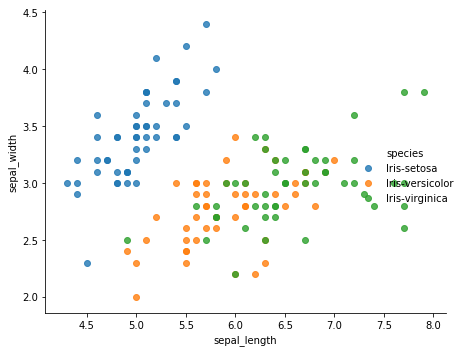

In [16]:
sns.lmplot(x='sepal_length', y='sepal_width', hue='species', data=data, fit_reg=False)

We can see that Versicolor and Virginica tend to have similar sepal lengths when their petal lengths are in the range of 4-6 inches. What does this mean for the classifier's ability to distinguish between the two?

Let's try again with `petal_length` and `petal_width`.

In [17]:
train_and_evaluate_on_subset(['petal_length', 'petal_width'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmp_fbmc4bv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x124c18cc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 i

/usr/local/miniconda3/envs/ml_tutorials/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


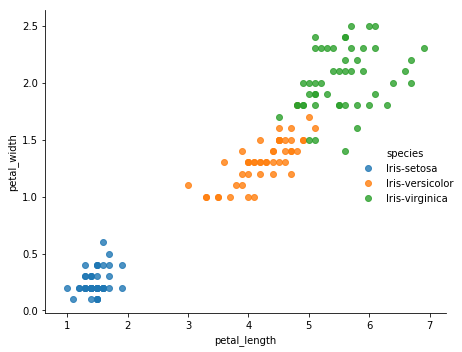

In [18]:
sns.lmplot(x='petal_length', y='petal_width', hue='species', data=data, fit_reg=False)

Why is the accuracy higher this time?